# PRACTICA 1 - Deep learning para Series Temporales

##LIBRERIAS
Se importan las bibliotecas necesarias para trabajar con datos, visualizaciones y modelos de redes neuronales.

1. `os`: Funciones para interactuar con el sistema operativo.
2. `numpy`: Cálculos numéricos y arreglos multidimensionales en Python.
3. `keras`: API de alto nivel para construir y entrenar modelos de aprendizaje profundo.
4. `datetime`: Trabajar con fechas y horas.
5. `IPython` y `IPython.display`: Mejorar la interacción y visualización en Jupyter Notebook.
6. `matplotlib.pyplot`: Crear gráficos y visualizaciones en Python.
7. `matplotlib`: Biblioteca base para visualización de datos.
8. `pandas`: Manipulación y análisis de datos en Python.
9. `seaborn`: Crear gráficos estadísticos informativos.
10. `tensorflow`: Biblioteca de aprendizaje automático y aprendizaje profundo.


In [1]:
import os
import numpy as np
from tensorflow import keras
import datetime
import IPython
import IPython.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

##DATOS


###Obtención de los datos
Se descarga y descomprime un conjunto de datos llamado "jena_climate_2009_2016.csv".  
Este conjunto de datos incluye 14 características distintas, como la temperatura del aire, la presión atmosférica y la humedad. Estos datos se recopilaron cada 10 minutos, a partir de 2003. Por eficiencia, solo se utilizarán los datos recogidos entre 2009 y 2016.



1. `!wget`: Comando para descargar el archivo .zip del conjunto de datos desde el enlace proporcionado.
2. `!unzip`: Comando para descomprimir el archivo .zip y extraer el archivo .csv.


In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-02-28 08:14:42--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.171.8, 52.216.39.48, 52.217.200.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.171.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  52.1MB/s    in 0.2s    

2024-02-28 08:14:42 (52.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


###Preparación de los datos
Primero leemos el csv con el método de pandas read_csv

In [3]:
df = pd.read_csv("jena_climate_2009_2016.csv")

En esta práctica, nos enfocaremos en realizar predicciones a nivel horario. Por lo tanto, iniciaremos ajustando los datos para que se muestren en intervalos de una hora en lugar de intervalos de 10 minutos.



In [4]:
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Para observar los datos vemos primero las 5 primeras líneas y después la evolución de ciertas características en el tiempo.

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


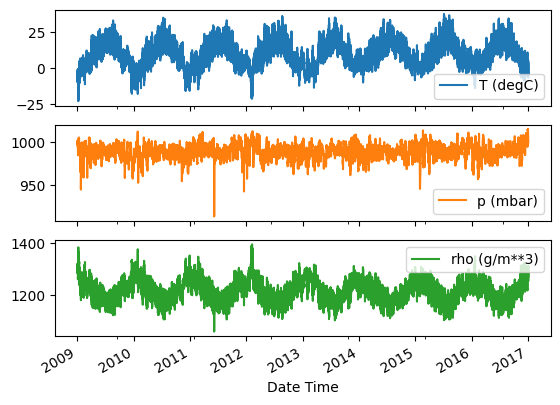

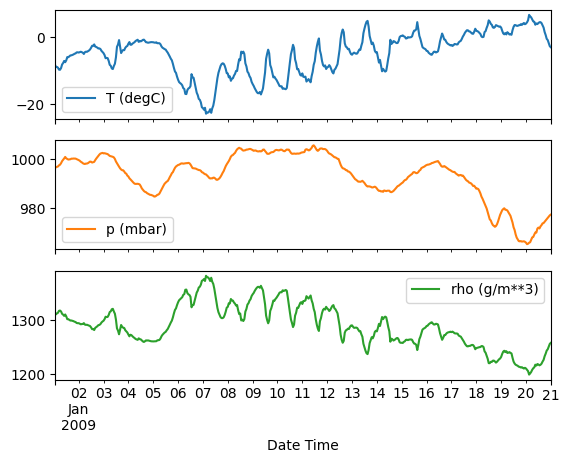

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

También observamos las estadísticas de cada una de las características del dataset.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70075.0,989.212743,8.360039,913.60,984.200,989.57,994.730,1015.30
T (degC),70075.0,9.448744,8.424157,-22.76,3.355,9.41,15.480,37.28
Tpot (K),70075.0,283.491357,8.505250,250.85,277.440,283.46,289.530,311.21
Tdew (degC),70075.0,4.954871,6.730648,-24.80,0.240,5.21,10.070,23.06
rh (%),70075.0,76.010481,16.475518,13.88,65.215,79.30,89.400,100.00
VPmax (mbar),70075.0,13.575524,7.741167,0.97,7.770,11.82,17.610,63.77
VPact (mbar),70075.0,9.533114,4.184117,0.81,6.220,8.86,12.360,28.25
VPdef (mbar),70075.0,4.042332,4.898866,0.00,0.870,2.19,5.300,46.01
sh (g/kg),70075.0,6.022018,2.656094,0.51,3.920,5.59,7.810,18.07
H2OC (mmol/mol),70075.0,9.639577,4.235312,0.81,6.280,8.96,12.490,28.74


####Ingeniería de características
Antes de comenzar a construir un modelo, es importante conocer los datos y asegurarte de proporcionar al modelo información con el formato adecuado.



#####Viento
La última columna de los datos, wd (grados), indica la dirección del viento en grados. Los ángulos no son buenos para ser utilizados como entrada en un modelo: 360° y 0° deberían estar cerca entre sí y tener una transición suave. La dirección no debería ser relevante si no hay viento.

Actualmente, la distribución de los datos del viento se ve así:

Text(0, 0.5, 'Wind Velocity [m/s]')

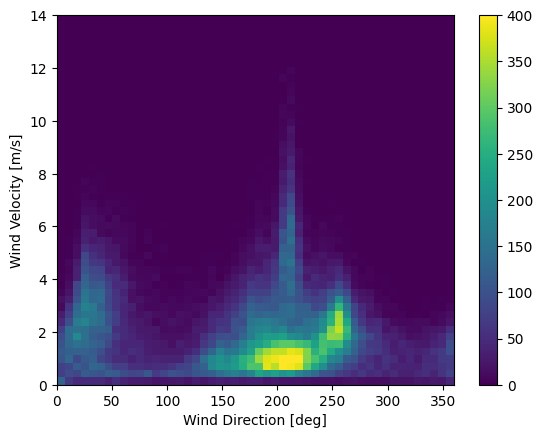

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Sin embargo, será más fácil para el modelo interpretar estos datos si convertimos las columnas de dirección y velocidad del viento en un vector de viento:

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

La distribución de los vectores de viento es mucho más sencilla para que el modelo pueda interpretarla correctamente:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

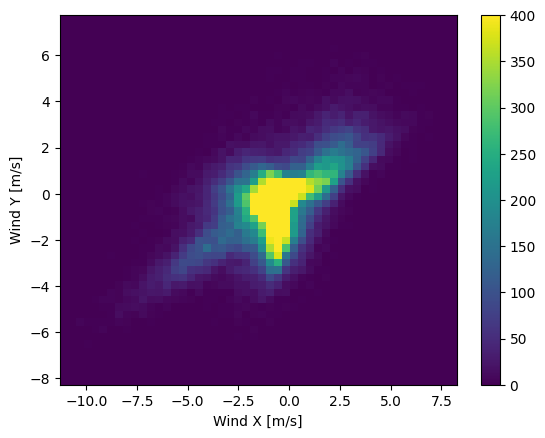

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#####Tiempo
De forma parecida, la columna de fecha y hora es interesante, pero no en su formato de texto. Primero se transforma a segundos:



In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

De manera análoga a la dirección del viento, el tiempo expresado en segundos no resulta práctico como entrada para el modelo. Los datos meteorológicos presentan patrones diarios y anuales recurrentes. Existen diversas maneras de abordar esta periodicidad.

Una opción es emplear transformaciones de seno y coseno para extraer información útil relacionada con la "Hora del día" y la "Estación del año":



In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

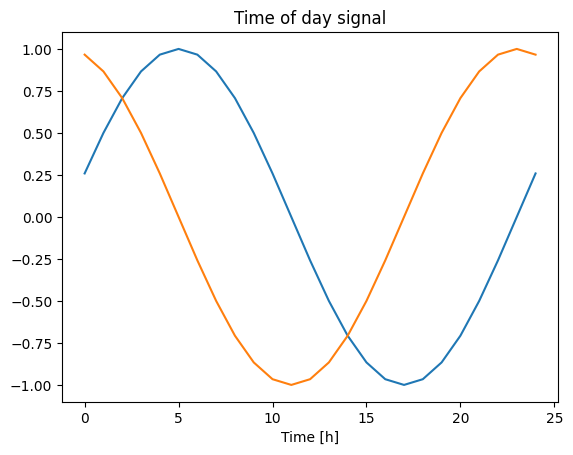

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

####Separación
Se utilizará una división (70%, 20%, 10%) para los conjuntos de entrenamiento, validación y prueba. Se debe tener en cuenta que los datos no se mezclan aleatoriamente antes de dividirse. Esto se debe a dos razones:

1. Garantiza que sea posible dividir los datos en ventanas de muestras consecutivas.
2. Asegura que los resultados de validación/prueba sean más realistas, al evaluarlos en datos recopilados después de que el modelo fuese entrenado.



In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

####Normalización
Es crucial escalar las características antes de entrenar una red neuronal. La normalización es un método común para realizar esta tarea: se resta la media y se divide por la desviación estándar de cada característica.

La media y la desviación estándar deben calcularse solo con los datos de entrenamiento para que los modelos no tengan acceso a los valores de los conjuntos de validación y prueba.

PD: *Se podría argumentar que el modelo tampoco debería tener acceso a valores futuros del conjunto de entrenamiento durante el mismo, y que la normalización debiera realizarse mediante promedios móviles. Sin embargo, esta práctica no se centra en eso.*

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

A continuación, se observan las distribuciones de las variables. Se puede ver que algunas siguen teniendo *colas largas* pero no hay anomalías.

<ipython-input-16-4ec9be458a7e>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


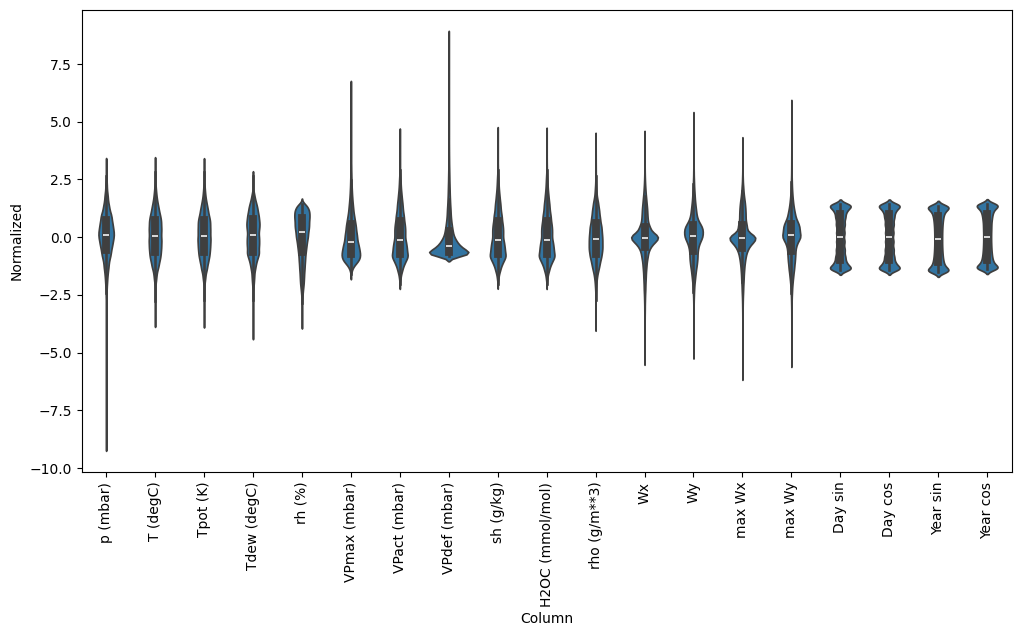

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

###DATA WINDOWING
Los modelos en este tutorial realizarán un conjunto de predicciones basadas en una ventana de muestras consecutivas de los datos.
Las características principales de las ventanas de entrada son:

1. El ancho (cantidad de pasos de tiempo) de las ventanas de entrada y etiquetas.
2. El desfase de tiempo entre ellas.
3. Qué características se utilizan como entradas, etiquetas o ambas.

En esta sección se crea la clase que se encarga de realizar dicho ventaneo de los datos. Como no es de interés en esta práctica no nos centraremos en explicar dicho proceso. No obstante para más información acceder a [Notebook Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing)

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

##MODELOS
A continuación comienza el proceso de definición y prueba de diferentes modelos con diferentes hiperparámetros.   
Para ello primero comprobamos que hasta ahora el código funciona correctamente con un único modelo.
Definimos una función de compilación y entrenamiento.

In [22]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Comprobamos que la clase WindowGenerator funciona correctamente.

In [23]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

Inicializamos dos diccionarios para almacenar tanto la precisión de validación como la de prueba.

In [24]:
val_performance = {}
performance = {}

Creamos un modelo secuencial LSTM utilizando TensorFlow Keras el cual consta de dos capas:

1. Capa LSTM con 32 unidades, donde `return_sequences=True` indica que la capa devuelve la secuencia completa de salidas para cada muestra en el lote.
2. Capa densa con 1 unidad para producir la salida.



In [25]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Finalmente, compilamos y entrenamos el modelo con la función definida anteriormente.  
Podemos observar que obtenemos una pérdida de 0.0056 y un MAE de 0.0.516.

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 9ms/step - loss: 0.0056 - mean_absolute_error: 0.0516


###KERAS TUNING (Búsqueda de mejores hiperparámetros)
Una vez comprobado que todo funciona correctamente, se realiza una búsqueda de hiperparámetros para encontrar la mejor configuración de una red neuronal recurrente (RNN) utilizando Keras Tuner y TensorFlow.

1. Primero, se instala e importa Keras Tuner y TensorFlow.

2. Luego, se define una función llamada `ajustar_tasa_aprendizaje` que ajusta la tasa de aprendizaje en función de la época. La tasa de aprendizaje se reduce un 20% cada par de épocas.

3. Se crea una función llamada `build_model` que construye y compila un modelo de Keras. Esta función toma un objeto de hiperparámetros como argumento y utiliza las opciones de hiperparámetros seleccionadas para configurar el número de unidades en la capa LSTM, la función de activación, el optimizador y la tasa de aprendizaje.

4. Se define un callback de Early Stopping que monitorea el 'val_loss' y detiene el entrenamiento cuando no se observa una mejora después de un número específico de épocas (en este caso, 4).

5. Se configura un callback de LearningRateScheduler que utiliza la función `ajustar_tasa_aprendizaje` para cambiar la tasa de aprendizaje a medida que avanza el entrenamiento.

6. Se crea una lista de callbacks que incluye Early Stopping y LearningRateScheduler.

7. Se construye un objeto de Keras Tuner, en este caso, utilizando RandomSearch, con la función `build_model`, el objetivo a optimizar (val_mean_absolute_error), el número máximo de iteraciones (10) y el número de ejecuciones por iteración (3).

8. Finalmente, se ejecuta la búsqueda de hiperparámetros utilizando el método `search` en el objeto tuner, proporcionando los datos de entrenamiento y validación, el número de épocas y los callbacks.

PD: Mencionar que no se añade un dropout recurrente para que el entrenamiento se realice en GPU y sea más rápido. Una vez obtenida la mejor solución se le añadirán ciertos parámetros y capas para ver si se puede mejorar esta.


In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras

# Función que define cómo se ajustará la tasa de aprendizaje en función de la época
def ajustar_tasa_aprendizaje(epoca, tasa_actual):
    # Se reduce la tasa de aprendizaje a la mitad cada 10 épocas
    if epoca % 2 == 0:
        return tasa_actual * 0.8
    else:
        return tasa_actual

# Función para construir el modelo de Keras
def build_model(hp):
    units = hp.Choice('units', values=[16, 32, 64])
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    optimizerchoice = hp.Choice('optimizer',  values=['adam', 'rmsprop'])
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=units, activation=activation, input_shape=(wide_window.input_width, num_features)))
    model.add(keras.layers.Dense(1))
    optimizer = {'adam': keras.optimizers.Adam(learning_rate=lr), 'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)}[optimizerchoice]
    model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

# Callback de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')

# Configurar el callback LearningRateScheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(ajustar_tasa_aprendizaje)

# Configurar Callbacks
callbacks = [early_stopping, lr_scheduler]

# Construir el modelo de Keras para usar con scikit-learn
tuner = kt.RandomSearch(build_model, objective='val_mean_absolute_error', max_trials=10, executions_per_trial=3, directory='output', project_name='KerasTuner')

# Realizar la búsqueda de hiperparámetros
tuner.search(wide_window.train, epochs=20, validation_data=wide_window.val, callbacks=callbacks)


Trial 10 Complete [00h 33m 35s]
val_mean_absolute_error: 0.2543819049994151

Best val_mean_absolute_error So Far: 0.2542482316493988
Total elapsed time: 05h 20m 32s


Finalmente se obtiene y muestra los hiperparámetros óptimos después de realizar la búsqueda de hiperparámetros con Keras Tuner.

1. Se utiliza el método `get_best_hyperparameters` en el objeto tuner para obtener los mejores hiperparámetros encontrados durante la búsqueda.

2. A continuación, se imprime un mensaje que indica los valores óptimos de los hiperparámetros seleccionados, incluyendo el número de unidades en la primera capa densamente conectada, la tasa de aprendizaje óptima para el optimizador, el optimizador seleccionado y la función de activación óptima.

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} with the optimizer {best_hps.get('optimizerchoice')}.
The best activation function is {best_hps.get('activation')}'.
""")

Observamos que los hiperparámetros que minimizan el error son una capa LSTM con 64 units con función de activación ReLu el optimizador RMSProp y una tasa de aprendizaje de 0.001. Creamos otro nuevo modelo al que añadimos dos capas densas de 64 y 32 neuronas para ver si mejoran la precisión. Además, añadimos dos capas dropout, pero no dropout recurrente ya que entonces el modelo no se puede entrenar en GPU.

In [26]:
# Función que define cómo se ajustará la tasa de aprendizaje en función de la época
def ajustar_tasa_aprendizaje(epoca, tasa_actual):
    # Se reduce la tasa de aprendizaje a la mitad cada 10 épocas
    if epoca % 2 == 0:
        return tasa_actual * 0.8
    else:
        return tasa_actual

#Creamos modelo
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, activation='relu', input_shape=(wide_window.input_width, num_features)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1))

#Optimizador
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

#Compilamos modelo
model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Callback de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')

# Configurar el callback LearningRateScheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(ajustar_tasa_aprendizaje)

# Configurar Callbacks
callbacks = [early_stopping, lr_scheduler]

history = model.fit(wide_window.train, epochs=20,
                      validation_data=wide_window.val,
                      callbacks=[early_stopping])

Epoch 1/20
1533/1533 [==============================] - 32s 20ms/step - loss: 0.1633 - mean_absolute_error: 0.3108 - val_loss: 0.1692 - val_mean_absolute_error: 0.3154
Epoch 2/20
1533/1533 [==============================] - 30s 19ms/step - loss: 0.1339 - mean_absolute_error: 0.2834 - val_loss: 0.1911 - val_mean_absolute_error: 0.3319
Epoch 3/20
1533/1533 [==============================] - 28s 18ms/step - loss: 0.1303 - mean_absolute_error: 0.2791 - val_loss: 0.1813 - val_mean_absolute_error: 0.3192
Epoch 4/20
1533/1533 [==============================] - 29s 19ms/step - loss: 0.1290 - mean_absolute_error: 0.2774 - val_loss: 0.2105 - val_mean_absolute_error: 0.3514
Epoch 5/20
1533/1533 [==============================] - 28s 18ms/step - loss: 0.1284 - mean_absolute_error: 0.2765 - val_loss: 0.1685 - val_mean_absolute_error: 0.3183
Epoch 6/20
1533/1533 [==============================] - 30s 19ms/step - loss: 0.1280 - mean_absolute_error: 0.2760 - val_loss: 0.1955 - val_mean_absolute_error:

Se observa que se obteine un modelo con un rendimiento parecido al anterior, e incluso peor, por lo que concluimos que no mejora el modelo.


##CONCLUSIONES
En la práctica presentada se han explorado mejoras en la ingeniería de características de los datos como la vectorización de dirección y velocidad del viento (agrega información espacial) y las transformaciones sinusoidales del tiempo (incorporan periodicidad)
Además, la práctica proporciona el código necesario para realizar una búsqueda de hiperparámetros óptimos con Keras Tuner, además de entrenar y evaluar el mejor modelo encontrado. Es importante mencionar que una búsqueda más amplia podría mejorar el rendimiento del modelo y la calidad de sus predicciones.
Cabe mencionar que en esta práctica no se ha implementado recurrent dropout debido a que aumentaba drásticamente el coste computacional. No obstante, su estudio para ver si mejora el rendimiento del modelo sería algo que debería estudiarse.